# Libs

In [1]:
import os
import json
import time
import random
import math
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorly.decomposition import non_negative_tucker
from tensorly import tucker_to_tensor

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal, constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

from utils import *
from ASC import *

from sklearn.neighbors import NearestNeighbors

Using numpy backend.


# Generate Road Network

In [2]:
G = nx.generators.lattice.grid_graph(dim=[25, 40])
for u, v in G.edges:
    weight = 400 + 100 * np.random.rand()
    G.add_edge(u, v, weight=weight)

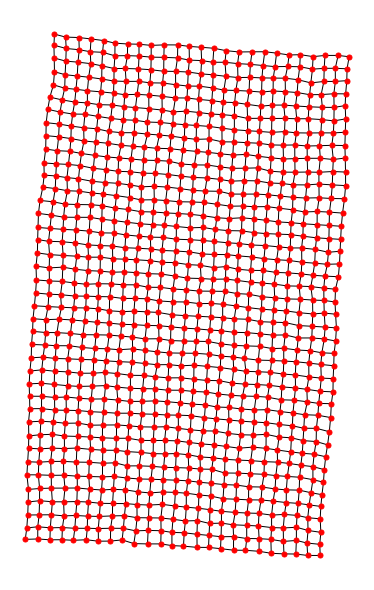

In [3]:
plt.rc("font", family="Times New Roman", size=5)
plt.figure(figsize=(5, 8))
nx.draw(
    G, with_labels=False, node_size=25, node_color='r',
    pos=nx.kamada_kawai_layout(G, weight="weight")
)
plt.savefig("./TrafficGridNetwork_1.png", dpi=300)

# Generate OD Flow
*selecting from path set

In [108]:
def select_od_pairs(G, ratio):
    """
    Select all Boundary nodes and a portion of inside nodes in G.
    Params: G, grid network
    Params: ratio, the fraction of inside nodes
    """
    # init node set
    nodeSet = list(G.nodes)

    # get max node idx
    maxNode = 0
    for idx, (u, v) in enumerate(nodeSet):
        if u > maxNode:
            maxNode = u

    # add boundary nodes
    boundNode = nodeSet[:maxNode] + nodeSet[-maxNode:]
    remainNodeSet = nodeSet[maxNode:-maxNode]

    # randomly select a portion of remaining nodes
    innerNode = []
    numRemain = int(ratio * len(remainNodeSet))
    for i in range(numRemain):
        node = random.choice(remainNodeSet)
        remainNodeSet.remove(node)
        innerNode.append(node)

    return boundNode + innerNode


def expntl(lamda):
    """
    Negative exponential distribution
    Params: lamda, mean of the distribution
    """
    x = random.random()
    return -lamda * math.log(x)


def generate_od_demand_pattern(odNodeSet, mean):
    """
    Generate daily OD demand.
    Params: odNodeSet, set of O/D nodes
    Params: mean, mean value of the negative exponential distribution
    """
    odPairSet = [(u, v) for u in odNodeSet for v in odNodeSet if u != v]

    odDemand = {}
    for idx, pair in enumerate(odPairSet):
        odDemand[pair] = int(np.abs(np.random.normal(mean,mean/3)))
    return odPairSet, odDemand


def get_cost(G, path):
    """
    Get path cost in a weighted network G.
    """
    cost = 0
    for idx, o_node in enumerate(path[:-1]):
        d_node = path[idx + 1]
        edgeCost = G.get_edge_data(o_node, d_node)["weight"]
        cost += edgeCost
    return cost


def generate_path_set(G, o_node, d_node, k):
    """
    Get k shortest paths for o_node to d_node in network G.
    """
    pathSet = {}
    for idx, path in enumerate(
        nx.shortest_simple_paths(G, o_node, d_node, weight="weight")
    ):
        if idx < 5:
            cost = get_cost(G, path)
            pathSet[idx] = {"path": path, "cost": cost}
            # cost_list.append(cost)
            # print(path,cost)
        else:
            break
    return pathSet


def sample_demand(odDemand, penetration):
    '''
    Get daily CV demand from odDemand by penetration.
    '''
    nodePair_to_idx = {}
    demandContainer = []
    for idx, nodePair in enumerate(odDemand):
        nodePair_to_idx[nodePair] = idx
        demandContainer += np.tile(str(idx), odDemand[nodePair]).tolist()

    sampleDemand = np.sum(list(odDemand.values())) * penetration
    return np.random.choice(demandContainer,size = int(sampleDemand))

In [109]:
odNodeSet = select_od_pairs(G, ratio=0.025)
numOdPair = len(odNodeSet) * (len(odNodeSet) - 1)
print(
    "There are {:d} OD node and {:d} pairs in total.".format(len(odNodeSet),
                                                             numOdPair)
)

odPairSet, odDemand = generate_od_demand_pattern(odNodeSet, mean= 240)

There are 101 OD node and 10100 pairs in total.


In [110]:
x = np.arange(48)
deno = np.sum(np.abs(np.sin(np.pi / 24 * x)))
nume = np.abs(np.sin(np.pi / 24 * x))
frac = 1.5 * nume / deno

frac_tile = np.tile(frac,(numOdPair,1)).T
demand_tile = np.tile(np.array(list(odDemand.values())), (48,1))
od_flow = np.ceil(frac_tile * demand_tile)

In [111]:
demand = od_flow.sum(axis=1).sum()

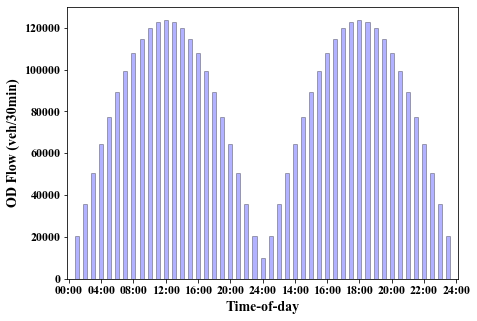

In [197]:
plt.rc('font', family='Times New Roman', size=12)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()
plt.bar(x, od_flow.sum(axis=1),
        color='b', alpha=0.3,
        edgecolor='k', width=0.5)
plt.xlim([-0.2, 48.2])
plt.ylabel('OD Flow (veh/30min)', fontdict={'size': 14})
plt.xlabel('Time-of-day', fontdict={'size': 14})
xticks = plt.xticks(np.arange(0, 49, 4), ['00:00', '04:00', '08:00', '12:00',
                                            '16:00', '20:00', '24:00', '14:00',
                                            '16:00', '18:00', '20:00', '22:00', '24:00'])
plt.savefig('./sin_cumulative_demand.png',dpi = 500)

In [ ]:
plt.rc('font', family='Times New Roman', size=12)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()
plt.bar(x[np.arange(0, 144, 6)] + 3, demand * nume_reduced,
        color='b', alpha=0.3,
        edgecolor='k', width=5)
plt.xlim([-0.2, 144.2])
plt.ylabel('OD Flow (veh/30min)', fontdict={'size': 14})
plt.xlabel('Time-of-day', fontdict={'size': 14})
xticks = plt.xticks(np.arange(0, 145, 24), ['00:00', '04:00', '08:00', '12:00',
                                            '16:00', '20:00', '24:00', '14:00',
                                            '16:00', '18:00', '20:00', '22:00', '24:00'])
#plt.savefig('./sin_cumulative_demand.png',dpi = 500)

In [114]:
month_od_flow = np.zeros((30,od_flow.shape[0],od_flow.shape[1]))
for day in range(30):
    od_flow_new_day = od_flow + np.random.normal(0,1,od_flow.shape)
    month_od_flow[day] = np.round(np.abs(od_flow_new_day))
#np.save('y_test.npy',month_od_flow)

In [130]:
penetration = 0.05
y_test = month_od_flow.copy()
y_train_penetration = np.random.normal(penetration,0.02,y_test.shape)
y_train = np.round(y_test * y_train_penetration)

In [131]:
y_scale = y_train / penetration
#np.save('y_train.npy',y_train)

In [ ]:
since = time.time()
core, factors = non_negative_tucker(y_scale,
                                    rank=[25,40,4000],
                                    init='random',
                                    verbose=1,
                                    n_iter_max=30)
y_recon = tucker_to_tensor(core, factors)
y_recon = y_recon + np.abs(np.random.normal(0,1,y_recon.shape))

print("\n[Stats] linear projection MAE: {:.2f} | reconstructed MAE: {:.2f}".format(
    mae(y_scale,y_test),
    mae(y_recon,y_test)
))
print("[Stats] linear projection MAPE: {:.2f}% | reconstructed MAPE: {:.2f}%".format(
    100 * mape(y_scale,y_test),
    100 * mape(y_recon,y_test)
))
print("[Stats] linear projection MSPE: {:.2f}% | reconstructed MSPE: {:.2f}%".format(
    100 * mspe(y_scale,y_test),
    100 * mspe(y_recon,y_test)
))
print("[Stats] linear projection Sparsity: {:.2f}% | reconstructed Sparsity: {:.2f}% | true: {:.2f}% ".format(
    100 * len(np.where(np.round(y_scale) == 0)[0]) / y_test.size,
    100 * len(np.where(np.round(y_recon) == 0)[0]) / y_test.size,
    100 * len(np.where(y_test == 0)[0]) / y_test.size,
))
duration = time.time() - since

# LCAE

In [168]:
def build_ae(input_shape, latent_dim, leak_rate, drop_rate):
    x_in = Input(shape=(input_shape,))

    def build_dense(h, units, leak_rate=leak_rate, drop_rate=drop_rate):
        h = Dense(units=units,
                  activation=None,
                  kernel_initializer=he_normal())(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(leak_rate)(h)
        h = Dropout(rate=drop_rate)(h)
        return h

    h = build_dense(x_in, 256)
    h = build_dense(h, 128)
    latent = Dense(units=latent_dim,
                   activation='relu',
                   kernel_initializer=he_normal(),
                   name='latency')(h)
    h = build_dense(latent, 128)
    h = build_dense(h, 256)
    h = Dense(units=input_shape,
              activation='relu',
              kernel_initializer=he_normal(),
              name='recon')(h)

    model = Model(inputs=x_in, outputs=[latent, h])
    model.compile(loss='mse', optimizer=Adam(3e-4), metrics=['mae'])

    return model

In [148]:
y_recon_samples = sample_split(y_recon)
y_test_single = individualize(sample_split(y_test))
y_recon_single = individualize(y_recon_samples)

In [151]:
knn = NearestNeighbors(n_neighbors=30,n_jobs=-1)
knn = knn.fit(y_test_single)
train_neighbors = knn.kneighbors()

In [157]:
asc = ASC(neighborset=train_neighbors, window_size=6)
y_pred_single = asc.predict_instwise(y_recon_single,
                                     y_test_single,
                                     interp_mode='uniform',
                                     num_epochs=1,
                                     num_iterations=40,
                                     beta_a=9, beta_b=1)

[Stats] number of neighbors: 30
****************************** Epoch 1 Starts. ******************************
[ASC epoch-1] [Iteration-1] MAE: 1.904600 | MSPE: 0.0625 | duration: 5.7 sec.
[ASC epoch-1] [Iteration-2] MAE: 1.877408 | MSPE: 0.0608 | duration: 11.4 sec.
[ASC epoch-1] [Iteration-3] MAE: 1.853663 | MSPE: 0.0593 | duration: 16.9 sec.
[ASC epoch-1] [Iteration-4] MAE: 1.832949 | MSPE: 0.0581 | duration: 22.5 sec.
[ASC epoch-1] [Iteration-5] MAE: 1.814758 | MSPE: 0.0570 | duration: 28.2 sec.
[ASC epoch-1] [Iteration-6] MAE: 1.798738 | MSPE: 0.0561 | duration: 33.8 sec.
[ASC epoch-1] [Iteration-7] MAE: 1.784602 | MSPE: 0.0554 | duration: 39.4 sec.
[ASC epoch-1] [Iteration-8] MAE: 1.772106 | MSPE: 0.0547 | duration: 45.1 sec.
[ASC epoch-1] [Iteration-9] MAE: 1.760980 | MSPE: 0.0542 | duration: 50.8 sec.


In [160]:
y_pred_day = recover_day_individual(y_pred_single,num_pairs=10100)

print("\n[Stats] linear projection MAE: {:.2f} | reconstructed MAE: {:.2f}".format(
    mae(y_scale,y_test),
    mae(y_pred_day,y_test)
))
print("[Stats] linear projection MAPE: {:.2f}% | reconstructed MAPE: {:.2f}%".format(
    100 * mape(y_scale,y_test),
    100 * mape(y_pred_day,y_test)
))
print("[Stats] linear projection MSPE: {:.2f}% | reconstructed MSPE: {:.2f}%".format(
    100 * mspe(y_scale,y_test),
    100 * mspe(y_pred_day,y_test)
))
print("[Stats] linear projection Sparsity: {:.2f}% | reconstructed Sparsity: {:.2f}% | true: {:.2f}% ".format(
    100 * len(np.where(np.round(y_scale) == 0)[0]) / y_test.size,
    100 * len(np.where(np.round(y_pred_day) == 0)[0]) / y_test.size,
    100 * len(np.where(y_test == 0)[0]) / y_test.size,
))

In [ ]:
latent_vec = np.random.rand(1290, 300)
ae = build_ae(y_recon_samples.reshape(1290, -1).shape[1],
              latent_dim=latent_vec.shape[1],
              leak_rate=0.3, drop_rate=0.5)
target = y_recon_samples.reshape(1290, -1)

X_train = y_recon_samples.reshape(1290, -1)
target_train = [latent_vec, target]
X_test = X_train.copy()
target_test = [latent_vec, X_test]

hist = ae.fit(X_train, target_train,
              validation_data = [X_test, target_test],
              batch_size=16, epochs=50,
              shuffle=True, verbose=1)

In [195]:
y_pred = ae.predict(X_test)

y_pred_day = recover_day_pred(y_pred[1].reshape(1290,6,10100))

print("\n[Stats] linear projection MAE: {:.2f} | reconstructed MAE: {:.2f}".format(
    mae(y_scale,y_test),
    mae(y_pred_day,y_test)
))
print("[Stats] linear projection MAPE: {:.2f}% | reconstructed MAPE: {:.2f}%".format(
    100 * mape(y_scale,y_test),
    100 * mape(y_pred_day,y_test)
))
print("[Stats] linear projection MSPE: {:.2f}% | reconstructed MSPE: {:.2f}%".format(
    100 * mspe(y_scale,y_test),
    100 * mspe(y_pred_day,y_test)
))
print("[Stats] linear projection Sparsity: {:.2f}% | reconstructed Sparsity: {:.2f}% | true: {:.2f}% ".format(
    100 * len(np.where(np.round(y_scale) == 0)[0]) / y_test.size,
    100 * len(np.where(np.round(y_pred_day) == 0)[0]) / y_test.size,
    100 * len(np.where(y_test == 0)[0]) / y_test.size,
))


[Stats] linear projection MAE: 6.54 | reconstructed MAE: 1.64
[Stats] linear projection MAPE: 81.83% | reconstructed MAPE: 20.46%
[Stats] linear projection MSPE: 66.07% | reconstructed MSPE: 4.77%
[Stats] linear projection Sparsity: 68.55% | reconstructed Sparsity: 4.62% | true: 2.24% 


# Path & Network effect analysis

In [ ]:
num_trip = 100
PATH = {}
sp = time.time()
for idx in range(num_trip):
    o_node = generate_node(G)
    d_node = generate_node(G)
    if o_node == d_node:
        continue
    pathSet = generate_path_set(G, o_node, d_node)

    PATH[str(o_node) + str(d_node)] = pathSet
ep = time.time()
print("[Timer] Duration: {:.2f}".format(ep - sp))

In [ ]:
with open("./PATH.json", "w") as f:
    json.dump(PATH, f)